# Notebook 07: Phase III — Full Catalog Analysis

**Objective:** Apply the Flynn (2025) Linear Model and the Schneider (2026) Tapered Model
to all 175 galaxies in the SPARC catalog. Use BIC model selection to determine which
model is preferred per galaxy, then test whether the taper scale $R_t$ correlates
with the physical disk scale length $R_{disk}$ and whether the preference varies with
Central Surface Brightness $\Sigma_0$.

## Models Under Test

| Model | Formula | Parameters |
|-------|---------|------------|
| **Flynn 2025 (Linear)** | $V_{\text{model}} = V_{\text{bary}} + \omega R$ | $\omega$ (1 param) |
| **Schneider 2026 (Tapered)** | $V_{\text{model}} = V_{\text{bary}} + \frac{\omega R}{1 + R/R_t}$ | $\omega, R_t$ (2 params) |

## Baryonic Velocity (Phase III Upgrade)

Uses the robust signed-square method (Lelli et al. 2016 Eq. 2):
$$V_{\text{bary}} = \sqrt{|V_{\text{gas}}|V_{\text{gas}} + \Upsilon_{\text{disk}}|V_{\text{disk}}|V_{\text{disk}} + \Upsilon_{\text{bulge}}|V_{\text{bulge}}|V_{\text{bulge}}}$$

Negative terms reduce $V_{\text{bary}}$ physically; if the sum is negative, that radius is masked.

## Deliverables

- `results/tables/phase_iii_full_results.csv`
- `results/figures/phase_iii_bic_histogram.png`
- `results/figures/phase_iii_Rt_vs_Rd.png`

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.optimize import curve_fit
from pathlib import Path

from src.physics import (
    compute_v_bary,
    fit_omega,
    compute_bic,
    TaperedFitResult,
)
from src.ingest import parse_sparc_metadata_mrt
from src.database import get_engine, get_session, query_profiles_as_dataframe
from src.utils import setup_logger, get_project_root

sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

# Constants — consistent with all prior notebooks
UPSILON_DISK  = 0.5
UPSILON_BULGE = 0.7
RMSE_FAIL_THRESHOLD = 50.0   # km/s  (flag as Fit Failed above this)
METHOD_VERSION = 'v4_phase3_catalog'

# Paths
PROJECT_ROOT = get_project_root()
RESULTS_DIR  = PROJECT_ROOT / 'results'
TABLES_DIR   = RESULTS_DIR / 'tables'
FIGURES_DIR  = RESULTS_DIR / 'figures'
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')

Project root: C:\Projects\ISM\baryonic-omega-analysis


## 1. Robust Tapered Fitter

Carried forward from Notebook 06 with the following additions:
- Wider `omega` upper bound (200 km/s/kpc) to accommodate extreme outliers.
- `r_max`-scaled `R_t` bounds so that very extended galaxies (e.g. DDO galaxies
  with large HI disks) can still fit a saturation radius beyond the data.
- Four initial-guess strategies to escape local minima.

In [2]:
def fit_omega_tapered_robust(
    radius, v_obs, v_err, v_bary,
    galaxy_id='unknown',
    method_version=METHOD_VERSION,
    upsilon_disk=UPSILON_DISK,
    upsilon_bulge=UPSILON_BULGE,
):
    """Robust tapered fit with adaptive initial guesses and wide R_t bounds.

    Tries four (omega, R_t) starting points and keeps the best chi^2.
    Returns an unconverged TaperedFitResult if all attempts fail.
    """
    radius  = np.asarray(radius,  dtype=np.float64)
    v_obs   = np.asarray(v_obs,   dtype=np.float64)
    v_err   = np.asarray(v_err,   dtype=np.float64)
    v_bary  = np.asarray(v_bary,  dtype=np.float64)

    n_points     = len(radius)
    positive_errs = v_err[v_err > 0]
    min_err      = float(np.min(positive_errs)) if len(positive_errs) > 0 else 1.0
    v_err_safe   = np.where(v_err > 0, v_err, min_err)
    flag_lt_bary = bool(np.any(v_obs < v_bary))

    def _model(r, omega, r_t):
        return v_bary + omega * r / (1.0 + r / r_t)

    r_max        = radius.max()
    omega_bounds = (0.0,  200.0)
    rt_bounds    = (0.1,  r_max * 5.0)

    initial_guesses = [
        [5.0,  r_max * 0.3],
        [10.0, r_max * 0.1],
        [3.0,  r_max * 1.0],
        [20.0, r_max * 2.0],
    ]

    best_result = None
    best_chi2   = np.inf

    for p0 in initial_guesses:
        p0c = [
            np.clip(p0[0], omega_bounds[0] + 1e-4, omega_bounds[1] - 1e-4),
            np.clip(p0[1], rt_bounds[0]    + 1e-4, rt_bounds[1]    - 1e-4),
        ]
        try:
            popt, pcov = curve_fit(
                _model, radius, v_obs,
                p0=p0c,
                sigma=v_err_safe, absolute_sigma=True,
                bounds=([omega_bounds[0], rt_bounds[0]],
                        [omega_bounds[1], rt_bounds[1]]),
                maxfev=10000,
            )
            v_try  = _model(radius, *popt)
            res    = v_obs - v_try
            chi2   = float(np.sum((res / v_err_safe) ** 2))
            if chi2 < best_chi2:
                best_chi2   = chi2
                best_result = (popt, pcov, v_try, res, chi2)
        except (RuntimeError, ValueError):
            continue

    # All attempts failed
    if best_result is None:
        nan    = float('nan')
        v_null = _model(radius, 0.0, 1.0)
        return TaperedFitResult(
            galaxy_id=galaxy_id, model_name='rational_taper_robust',
            omega_value=nan, omega_uncertainty=nan,
            rt_value=nan, rt_uncertainty=nan,
            chi_squared=nan, reduced_chi_squared=nan,
            residuals_rmse=nan, n_points=n_points, n_params=2,
            converged=False, flag_v_obs_lt_v_bary=flag_lt_bary,
            method_version=method_version,
            upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
            v_bary=v_bary, v_model=v_null, residuals=v_obs - v_null,
        )

    popt, pcov, v_model, residuals, chi2 = best_result
    omega_best, rt_best = float(popt[0]), float(popt[1])
    perr        = np.sqrt(np.diag(pcov))
    dof         = max(n_points - 2, 1)
    reduced_chi2 = chi2 / dof
    rmse        = float(np.sqrt(np.mean(residuals ** 2)))

    return TaperedFitResult(
        galaxy_id=galaxy_id, model_name='rational_taper_robust',
        omega_value=omega_best, omega_uncertainty=float(perr[0]),
        rt_value=rt_best,       rt_uncertainty=float(perr[1]),
        chi_squared=chi2, reduced_chi_squared=reduced_chi2,
        residuals_rmse=rmse, n_points=n_points, n_params=2,
        converged=True, flag_v_obs_lt_v_bary=flag_lt_bary,
        method_version=method_version,
        upsilon_disk=upsilon_disk, upsilon_bulge=upsilon_bulge,
        v_bary=v_bary, v_model=v_model, residuals=residuals,
    )


print('Robust tapered fitter (Phase III) ready.')

Robust tapered fitter (Phase III) ready.


## 2. Load Catalog & Metadata

In [3]:
# Parse SPARC MRT metadata for all 175 galaxies
metadata_path = PROJECT_ROOT / 'data' / 'raw' / 'SPARC_Lelli2016c.mrt'
meta_df       = parse_sparc_metadata_mrt(metadata_path)
meta_lookup   = meta_df.set_index('galaxy_id')

# Compute central surface brightness for each galaxy
# Sigma_0 = L_tot / (2 * pi * R_d^2)   [L_sun / kpc^2]
meta_df['Sigma_0_kpc2'] = (
    meta_df['luminosity_band_36'] * 1e9
    / (2.0 * np.pi * meta_df['r_disk_kpc'] ** 2)
)

print(f'Metadata loaded: {len(meta_df)} galaxies')
print(f'Columns available: {list(meta_df.columns)}')
meta_df[['galaxy_id', 'luminosity_band_36', 'r_disk_kpc', 'Sigma_0_kpc2']].head()

2026-02-24 08:55:23 | INFO     | src.ingest | Parsed metadata for 175 galaxies


Metadata loaded: 175 galaxies
Columns available: ['galaxy_id', 'hubble_type', 'distance_mpc', 'e_distance_mpc', 'inclination', 'e_inclination', 'luminosity_band_36', 'r_eff_kpc', 'sb_eff', 'r_disk_kpc', 'sb_disk', 'm_hi', 'r_hi_kpc', 'v_flat', 'e_v_flat', 'quality_flag', 'Sigma_0_kpc2']


,galaxy_id,luminosity_band_36,r_disk_kpc,Sigma_0_kpc2
0,CamB,0.075,0.47,5.403631e+07
1,D512-2,0.325,1.24,3.364032e+07
2,D564-8,0.033,0.61,1.411479e+07
3,D631-7,0.196,0.70,6.366198e+07
4,DDO064,0.157,0.69,5.248336e+07


In [4]:
# Enumerate all galaxies available in the database
engine  = get_engine()
session = get_session(engine)

all_galaxy_ids = meta_df['galaxy_id'].tolist()

# Quick availability check
available_ids = []
missing_ids   = []
for gid in all_galaxy_ids:
    df_test = query_profiles_as_dataframe(session, gid)
    if df_test.empty:
        missing_ids.append(gid)
    else:
        available_ids.append(gid)

session.close()

print(f'SPARC galaxies in metadata : {len(all_galaxy_ids)}')
print(f'Found in database          : {len(available_ids)}')
if missing_ids:
    print(f'Missing from database      : {len(missing_ids)} — {missing_ids[:10]}...')

SPARC galaxies in metadata : 175
Found in database          : 175


## 3. The Full-Catalog Fitting Loop

For each galaxy:
1. Extract radial profile from the database.
2. Compute $V_{\text{bary}}$ with the robust signed-square method.
3. Fit A — Flynn (2025) Linear: optimise $\omega$.
4. Fit B — Schneider (2026) Tapered: optimise $\omega$ and $R_t$.
5. Compute BIC for both; flag failures (non-convergence or RMSE > 50 km/s).

Progress is printed every 20 galaxies.

In [5]:
engine  = get_engine()
session = get_session(engine)

catalog_results = []
n_total  = len(available_ids)
n_failed = 0

for i, gid in enumerate(available_ids):

    # Progress update
    if i % 20 == 0:
        print(f'[{i:3d}/{n_total}]  Processing: {gid}')

    try:
        # ------------------------------------------------------------------
        # A. Extract data
        # ------------------------------------------------------------------
        df = query_profiles_as_dataframe(session, gid)
        if df.empty:
            raise ValueError('No profile data found')

        radius  = df['radius_kpc'].values
        v_obs   = df['v_obs'].values
        v_err   = df['v_err'].values
        v_gas   = df['v_gas'].values
        v_disk  = df['v_disk'].values
        v_bulge = df['v_bulge'].values

        # Require at least 3 points for the 2-parameter tapered fit
        if len(radius) < 3:
            raise ValueError(f'Too few data points ({len(radius)})')

        # ------------------------------------------------------------------
        # B. Compute V_bary — signed-square (robust) method
        # ------------------------------------------------------------------
        v_bary = compute_v_bary(
            v_gas, v_disk, v_bulge,
            upsilon_disk=UPSILON_DISK,
            upsilon_bulge=UPSILON_BULGE,
        )

        # ------------------------------------------------------------------
        # C. Fit A: Flynn (2025) Linear  — 1 free parameter (omega)
        # ------------------------------------------------------------------
        lin_fit = fit_omega(
            radius, v_obs, v_err, v_bary,
            galaxy_id=gid,
            method_version=METHOD_VERSION + '_linear',
            upsilon_disk=UPSILON_DISK,
            upsilon_bulge=UPSILON_BULGE,
        )

        # ------------------------------------------------------------------
        # D. Fit B: Schneider (2026) Tapered  — 2 free parameters (omega, R_t)
        # ------------------------------------------------------------------
        tap_fit = fit_omega_tapered_robust(
            radius, v_obs, v_err, v_bary,
            galaxy_id=gid,
            method_version=METHOD_VERSION + '_tapered',
            upsilon_disk=UPSILON_DISK,
            upsilon_bulge=UPSILON_BULGE,
        )

        # ------------------------------------------------------------------
        # E. BIC model comparison
        # ------------------------------------------------------------------
        bic_linear  = compute_bic(lin_fit.n_points, 1, lin_fit.chi_squared)
        bic_tapered = compute_bic(tap_fit.n_points, 2, tap_fit.chi_squared)
        delta_bic   = bic_linear - bic_tapered   # positive = Tapered preferred

        if   abs(delta_bic) < 2:  preferred = 'Indistinguishable'
        elif delta_bic > 0:       preferred = 'Tapered'
        else:                     preferred = 'Linear'

        # ------------------------------------------------------------------
        # F. Quality control
        # ------------------------------------------------------------------
        lin_ok  = lin_fit.converged  and lin_fit.residuals_rmse  <= RMSE_FAIL_THRESHOLD
        tap_ok  = tap_fit.converged  and tap_fit.residuals_rmse  <= RMSE_FAIL_THRESHOLD
        fit_ok  = lin_ok and tap_ok
        fit_flag = 'OK' if fit_ok else 'Fit Failed'
        if not fit_ok:
            n_failed += 1

        # ------------------------------------------------------------------
        # G. Pull metadata
        # ------------------------------------------------------------------
        if gid in meta_lookup.index:
            luminosity = float(meta_lookup.loc[gid, 'luminosity_band_36'])
            r_disk     = float(meta_lookup.loc[gid, 'r_disk_kpc'])
            sigma_0    = meta_df.loc[
                meta_df['galaxy_id'] == gid, 'Sigma_0_kpc2'
            ].iloc[0]
        else:
            luminosity = np.nan
            r_disk     = np.nan
            sigma_0    = np.nan

        catalog_results.append({
            'GalaxyID'         : gid,
            'N_pts'            : lin_fit.n_points,
            'Luminosity_1e9Lsun': luminosity,
            'R_disk_kpc'       : r_disk,
            'Sigma_0'          : sigma_0,      # L_sun / kpc^2
            # Linear fit
            'Linear_omega'     : lin_fit.omega_value,
            'Linear_omega_err' : lin_fit.omega_uncertainty,
            'Linear_RMSE'      : lin_fit.residuals_rmse,
            'Linear_chi2r'     : lin_fit.reduced_chi_squared,
            'Linear_BIC'       : bic_linear,
            'Linear_converged' : lin_fit.converged,
            # Tapered fit
            'Tapered_omega'    : tap_fit.omega_value,
            'Tapered_omega_err': tap_fit.omega_uncertainty,
            'Tapered_Rt'       : tap_fit.rt_value,
            'Tapered_Rt_err'   : tap_fit.rt_uncertainty,
            'Tapered_RMSE'     : tap_fit.residuals_rmse,
            'Tapered_chi2r'    : tap_fit.reduced_chi_squared,
            'Tapered_BIC'      : bic_tapered,
            'Tapered_converged': tap_fit.converged,
            # Model selection
            'Delta_BIC'        : delta_bic,
            'Preferred_Model'  : preferred,
            'Fit_Flag'         : fit_flag,
            # Flags
            'Flag_Vobs_lt_Vbary': lin_fit.flag_v_obs_lt_v_bary,
        })

    except Exception as exc:
        n_failed += 1
        catalog_results.append({
            'GalaxyID'         : gid,
            'N_pts'            : 0,
            'Fit_Flag'         : f'Error: {exc}',
            'Preferred_Model'  : 'N/A',
            'Delta_BIC'        : np.nan,
        })
        print(f'  ERROR — {gid}: {exc}')

session.close()

results_df = pd.DataFrame(catalog_results)
print(f'\n==== Loop complete ====')
print(f'Total processed : {len(results_df)}')
print(f'Fit Failed / Error: {n_failed}')
print(f'Success rate    : {(len(results_df) - n_failed) / len(results_df) * 100:.1f}%')

2026-02-24 08:55:23 | INFO     | src.physics | CamB: omega=1.0875 +/- 0.4782 km/s/kpc  chi2_r=4.98  RMSE=3.16 km/s
2026-02-24 08:55:23 | INFO     | src.physics | D512-2: omega=7.6494 +/- 0.8138 km/s/kpc  chi2_r=2.05  RMSE=5.51 km/s
2026-02-24 08:55:23 | INFO     | src.physics | D564-8: omega=5.9090 +/- 0.3866 km/s/kpc  chi2_r=0.50  RMSE=1.19 km/s
2026-02-24 08:55:23 | INFO     | src.physics | D631-7: omega=6.0526 +/- 0.1487 km/s/kpc  chi2_r=2.36  RMSE=3.19 km/s
2026-02-24 08:55:23 | INFO     | src.physics | DDO064: omega=11.5372 +/- 0.8832 km/s/kpc  chi2_r=0.78  RMSE=5.01 km/s
2026-02-24 08:55:23 | INFO     | src.physics | DDO154: omega=7.2104 +/- 0.0274 km/s/kpc  chi2_r=85.87  RMSE=5.46 km/s
2026-02-24 08:55:23 | INFO     | src.physics | DDO161: omega=2.9977 +/- 0.0280 km/s/kpc  chi2_r=3.17  RMSE=2.28 km/s
2026-02-24 08:55:23 | INFO     | src.physics | DDO168: omega=8.6673 +/- 0.2196 km/s/kpc  chi2_r=5.72  RMSE=4.00 km/s
2026-02-24 08:55:23 | INFO     | src.physics | DDO170: omega=3.3

[  0/175]  Processing: CamB


2026-02-24 08:55:23 | INFO     | src.physics | ESO563-G021: omega=5.4727 +/- 0.0712 km/s/kpc  chi2_r=50.59  RMSE=38.79 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F561-1: omega=1.2261 +/- 0.3266 km/s/kpc  chi2_r=1.56  RMSE=5.71 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F563-1: omega=4.8950 +/- 0.2322 km/s/kpc  chi2_r=5.92  RMSE=25.74 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F563-V1: omega=0.7183 +/- 0.3998 km/s/kpc  chi2_r=0.53  RMSE=3.32 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F563-V2: omega=10.9716 +/- 0.7951 km/s/kpc  chi2_r=4.02  RMSE=29.30 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F565-V2: omega=6.9411 +/- 0.4042 km/s/kpc  chi2_r=1.36  RMSE=7.54 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F567-2: omega=3.7303 +/- 0.5126 km/s/kpc  chi2_r=2.95  RMSE=10.83 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F568-1: omega=9.7663 +/- 0.4685 km/s/kpc  chi2_r=4.22  RMSE=25.53 km/s
2026-02-24 08:55:23 | INFO     | src.physics | F5

[ 20/175]  Processing: F568-3


2026-02-24 08:55:23 | INFO     | src.physics | NGC0024: omega=7.7156 +/- 0.1643 km/s/kpc  chi2_r=13.88  RMSE=28.57 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0055: omega=4.0611 +/- 0.0825 km/s/kpc  chi2_r=3.90  RMSE=6.32 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0100: omega=6.8200 +/- 0.2090 km/s/kpc  chi2_r=0.86  RMSE=4.70 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0247: omega=7.1540 +/- 0.0802 km/s/kpc  chi2_r=51.51  RMSE=23.48 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0289: omega=1.9692 +/- 0.0327 km/s/kpc  chi2_r=19.45  RMSE=26.51 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0300: omega=6.3084 +/- 0.1018 km/s/kpc  chi2_r=8.11  RMSE=11.14 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0801: omega=1.6577 +/- 0.0339 km/s/kpc  chi2_r=12.64  RMSE=19.85 km/s
2026-02-24 08:55:23 | INFO     | src.physics | NGC0891: omega=3.5789 +/- 0.0700 km/s/kpc  chi2_r=19.93  RMSE=25.89 km/s
2026-02-24 08:55:23 | INFO     | src.physics 

[ 40/175]  Processing: NGC1003


2026-02-24 08:55:24 | INFO     | src.physics | NGC2998: omega=2.7787 +/- 0.0325 km/s/kpc  chi2_r=22.70  RMSE=37.54 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3109: omega=8.4542 +/- 0.1399 km/s/kpc  chi2_r=2.70  RMSE=3.91 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3198: omega=2.8301 +/- 0.0169 km/s/kpc  chi2_r=113.07  RMSE=22.34 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3521: omega=5.7109 +/- 0.2332 km/s/kpc  chi2_r=0.54  RMSE=6.16 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3726: omega=2.6624 +/- 0.1127 km/s/kpc  chi2_r=1.78  RMSE=6.35 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3741: omega=7.0615 +/- 0.1432 km/s/kpc  chi2_r=7.15  RMSE=6.19 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3769: omega=3.0444 +/- 0.1299 km/s/kpc  chi2_r=8.79  RMSE=21.28 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC3877: omega=3.7697 +/- 0.2194 km/s/kpc  chi2_r=9.86  RMSE=20.70 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NG

[ 60/175]  Processing: NGC3917


2026-02-24 08:55:24 | INFO     | src.physics | NGC4138: omega=5.1032 +/- 0.4431 km/s/kpc  chi2_r=3.47  RMSE=17.41 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4157: omega=2.9221 +/- 0.1129 km/s/kpc  chi2_r=0.44  RMSE=6.25 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4183: omega=3.8165 +/- 0.0972 km/s/kpc  chi2_r=9.10  RMSE=16.74 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4214: omega=13.5909 +/- 0.5515 km/s/kpc  chi2_r=3.82  RMSE=13.04 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4217: omega=1.9246 +/- 0.1640 km/s/kpc  chi2_r=37.83  RMSE=43.15 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4389: omega=-3.8710 +/- 0.8018 km/s/kpc  chi2_r=12.11  RMSE=20.77 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC4559: omega=3.3934 +/- 0.0688 km/s/kpc  chi2_r=2.34  RMSE=8.15 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC5005: omega=4.2896 +/- 0.7974 km/s/kpc  chi2_r=0.69  RMSE=12.28 km/s
2026-02-24 08:55:24 | INFO     | src.physics |

[ 80/175]  Processing: NGC5033


2026-02-24 08:55:24 | INFO     | src.physics | NGC6674: omega=2.5830 +/- 0.0144 km/s/kpc  chi2_r=109.76  RMSE=43.41 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC6789: omega=50.0000 +/- 6.0070 km/s/kpc  chi2_r=0.49  RMSE=3.52 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC6946: omega=4.0620 +/- 0.0424 km/s/kpc  chi2_r=2.64  RMSE=10.94 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC7331: omega=2.7636 +/- 0.0301 km/s/kpc  chi2_r=7.68  RMSE=16.58 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC7793: omega=7.2962 +/- 0.3056 km/s/kpc  chi2_r=2.49  RMSE=9.75 km/s
2026-02-24 08:55:24 | INFO     | src.physics | NGC7814: omega=6.4622 +/- 0.0762 km/s/kpc  chi2_r=5.74  RMSE=12.61 km/s
2026-02-24 08:55:24 | INFO     | src.physics | PGC51017: omega=0.3374 +/- 0.3467 km/s/kpc  chi2_r=1.68  RMSE=4.66 km/s
2026-02-24 08:55:24 | INFO     | src.physics | UGC00128: omega=2.8306 +/- 0.0081 km/s/kpc  chi2_r=612.32  RMSE=35.11 km/s
2026-02-24 08:55:24 | INFO     | src.physics

[100/175]  Processing: UGC00891


2026-02-24 08:55:25 | INFO     | src.physics | UGC03546: omega=4.2701 +/- 0.0246 km/s/kpc  chi2_r=8.89  RMSE=31.01 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC03580: omega=3.6174 +/- 0.0264 km/s/kpc  chi2_r=36.30  RMSE=17.70 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC04278: omega=9.4212 +/- 0.2524 km/s/kpc  chi2_r=1.58  RMSE=6.35 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC04305: omega=0.5893 +/- 0.2067 km/s/kpc  chi2_r=2.63  RMSE=5.88 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC04325: omega=12.0526 +/- 0.3058 km/s/kpc  chi2_r=39.49  RMSE=17.97 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC04483: omega=10.8258 +/- 0.7183 km/s/kpc  chi2_r=1.84  RMSE=1.74 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC04499: omega=5.3653 +/- 0.1772 km/s/kpc  chi2_r=7.02  RMSE=7.14 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC05005: omega=2.5913 +/- 0.2075 km/s/kpc  chi2_r=1.00  RMSE=9.79 km/s
2026-02-24 08:55:25 | INFO     | src.phys

[120/175]  Processing: UGC05414


2026-02-24 08:55:25 | INFO     | src.physics | UGC06614: omega=2.2559 +/- 0.1229 km/s/kpc  chi2_r=1.33  RMSE=15.25 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06628: omega=0.4892 +/- 0.6361 km/s/kpc  chi2_r=0.67  RMSE=6.27 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06667: omega=9.4353 +/- 0.2203 km/s/kpc  chi2_r=22.92  RMSE=14.59 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06786: omega=6.3002 +/- 0.0266 km/s/kpc  chi2_r=57.69  RMSE=30.19 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06787: omega=6.2503 +/- 0.0201 km/s/kpc  chi2_r=106.21  RMSE=23.46 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06818: omega=5.8985 +/- 0.4293 km/s/kpc  chi2_r=1.77  RMSE=5.97 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06917: omega=7.0211 +/- 0.1916 km/s/kpc  chi2_r=7.38  RMSE=11.42 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC06923: omega=7.5470 +/- 0.5642 km/s/kpc  chi2_r=0.88  RMSE=4.23 km/s
2026-02-24 08:55:25 | INFO     | src.ph

[140/175]  Processing: UGC06973


2026-02-24 08:55:25 | INFO     | src.physics | UGC07608: omega=10.8736 +/- 0.7841 km/s/kpc  chi2_r=1.10  RMSE=6.57 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC07690: omega=8.0217 +/- 0.6174 km/s/kpc  chi2_r=4.36  RMSE=8.33 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC07866: omega=7.2332 +/- 1.0343 km/s/kpc  chi2_r=0.49  RMSE=2.64 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC08286: omega=8.5579 +/- 0.1012 km/s/kpc  chi2_r=50.04  RMSE=15.19 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC08490: omega=6.9885 +/- 0.1122 km/s/kpc  chi2_r=19.23  RMSE=15.91 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC08550: omega=8.4238 +/- 0.1874 km/s/kpc  chi2_r=19.26  RMSE=9.09 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC08699: omega=5.9018 +/- 0.0760 km/s/kpc  chi2_r=12.54  RMSE=18.52 km/s
2026-02-24 08:55:25 | INFO     | src.physics | UGC08837: omega=4.3691 +/- 0.3717 km/s/kpc  chi2_r=0.56  RMSE=1.88 km/s
2026-02-24 08:55:25 | INFO     | src.phy

[160/175]  Processing: UGC08837


2026-02-24 08:55:26 | INFO     | src.physics | UGC12632: omega=4.7651 +/- 0.1189 km/s/kpc  chi2_r=15.76  RMSE=12.55 km/s
2026-02-24 08:55:26 | INFO     | src.physics | UGC12732: omega=4.4157 +/- 0.0913 km/s/kpc  chi2_r=18.45  RMSE=15.39 km/s
2026-02-24 08:55:26 | INFO     | src.physics | UGCA281: omega=16.2376 +/- 0.9882 km/s/kpc  chi2_r=1.64  RMSE=2.02 km/s
2026-02-24 08:55:26 | INFO     | src.physics | UGCA442: omega=6.2565 +/- 0.0959 km/s/kpc  chi2_r=8.33  RMSE=5.10 km/s
2026-02-24 08:55:26 | INFO     | src.physics | UGCA444: omega=9.4443 +/- 0.4556 km/s/kpc  chi2_r=0.72  RMSE=2.76 km/s



==== Loop complete ====
Total processed : 175
Fit Failed / Error: 4
Success rate    : 97.7%


## 4. Summary Statistics

In [6]:
# Work only with galaxies that converged cleanly
good_df = results_df[
    results_df['Fit_Flag'] == 'OK'
].copy()

print(f'Quality-controlled sample: {len(good_df)} / {len(results_df)} galaxies')
print()

# Model preference breakdown
pref_counts = good_df['Preferred_Model'].value_counts()
print('Model preference (BIC):')
for model, count in pref_counts.items():
    pct = count / len(good_df) * 100
    print(f'  {model:20s}: {count:3d} ({pct:.1f}%)')

print()
print('Delta BIC statistics (Linear - Tapered):')
print(good_df['Delta_BIC'].describe().to_string())

print()
print('Tapered R_t statistics (kpc):')
tapered_ok = good_df[good_df['Tapered_converged'] == True]
print(tapered_ok['Tapered_Rt'].describe().to_string())

Quality-controlled sample: 171 / 175 galaxies

Model preference (BIC):
  Tapered             : 127 (74.3%)
  Linear              :  27 (15.8%)
  Indistinguishable   :  17 (9.9%)

Delta BIC statistics (Linear - Tapered):
count      171.000000
mean       625.203189
std       2325.533897
min        -53.530996
25%          0.968789
50%         49.858615
75%        212.323358
max      19023.775462

Tapered R_t statistics (kpc):
count    171.000000
mean      21.098144
std       45.022442
min        0.100000
25%        1.486950
50%        4.807696
75%       15.297286
max      322.950000


## 5. Save Master Results Table

In [7]:
out_csv = TABLES_DIR / 'phase_iii_full_results.csv'
results_df.to_csv(out_csv, index=False, float_format='%.6f')
print(f'Saved: {out_csv}')
print(f'Shape: {results_df.shape}')

# Copy to data/processed/ for manuscript data availability link
pub_csv = PROJECT_ROOT / 'data' / 'processed' / 'Schneider_2026_SPARC_Fit_Parameters.csv'
results_df.to_csv(pub_csv, index=False, float_format='%.6f')
print(f'Saved: {pub_csv}')

display(good_df.head(10))

Saved: C:\Projects\ISM\baryonic-omega-analysis\results\tables\phase_iii_full_results.csv
Shape: (175, 23)
Saved: C:\Projects\ISM\baryonic-omega-analysis\data\processed\Schneider_2026_SPARC_Fit_Parameters.csv


,GalaxyID,N_pts,Luminosity_1e9Lsun,R_disk_kpc,Sigma_0,Linear_omega,Linear_omega_err,Linear_RMSE,Linear_chi2r,Linear_BIC,...,Tapered_Rt,Tapered_Rt_err,Tapered_RMSE,Tapered_chi2r,Tapered_BIC,Tapered_converged,Delta_BIC,Preferred_Model,Fit_Flag,Flag_Vobs_lt_Vbary
0,CamB,9,0.075,0.47,5.403631e+07,1.087493,0.478219,3.157099,4.983637,42.066317,...,8.950000,127.167650,3.198807,5.847066,45.323908,True,-3.257591,Linear,OK,True
1,D512-2,4,0.325,1.24,3.364032e+07,7.649365,0.813763,5.505734,2.046812,7.526729,...,1.427526,1.374536,1.165172,0.099143,2.970875,True,4.555854,Tapered,OK,False
2,D564-8,6,0.033,0.61,1.411479e+07,5.908969,0.386604,1.185629,0.498165,4.282583,...,6.467550,6.351037,0.578257,0.174722,4.282406,True,0.000177,Indistinguishable,OK,False
3,D631-7,16,0.196,0.70,6.366198e+07,6.052644,0.148655,3.188664,2.357179,38.130269,...,35.950000,27.933240,3.489755,3.173808,49.978488,True,-11.848219,Linear,OK,True
4,DDO064,14,0.157,0.69,5.248336e+07,11.537224,0.883183,5.007009,0.784421,12.836528,...,1.506292,1.098994,2.606736,0.315092,9.059213,True,3.777315,Tapered,OK,False
5,DDO154,12,0.053,0.37,6.161587e+07,7.210355,0.027360,5.455923,85.867456,947.026926,...,3.250104,0.219907,1.512859,3.380845,38.778260,True,908.248667,Tapered,OK,False
6,DDO161,31,0.548,1.22,5.859776e+07,2.997670,0.028040,2.282883,3.166899,98.440966,...,18.755134,2.981061,1.638516,0.455402,20.074640,True,78.366326,Tapered,OK,False
7,DDO168,10,0.191,1.02,2.921818e+07,8.667336,0.219642,3.995752,5.717440,53.759544,...,20.600000,16.175847,3.641504,6.498395,56.592328,True,-2.832783,Linear,OK,False
8,DDO170,8,0.543,1.95,2.272745e+07,3.348746,0.049858,6.994671,40.473286,285.392447,...,2.912400,0.536485,1.980477,2.706450,20.397583,True,264.994863,Tapered,OK,False
9,ESO079-G014,15,51.733,5.08,3.190512e+08,5.489801,0.072227,15.142758,10.714590,152.712307,...,9.303252,1.648962,7.861483,2.271230,34.942086,True,117.770221,Tapered,OK,False


## 6. Money Plot 1 — $\Delta$BIC Histogram

**Interpretation zones (Kass & Raftery 1995):**
- $|\Delta\text{BIC}| < 2$: Indistinguishable (grey zone)
- $2 < \Delta\text{BIC} < 6$: Positive evidence for Tapered
- $\Delta\text{BIC} > 6$: Strong evidence for Tapered

$\Delta\text{BIC} < 0$ means Linear is preferred.

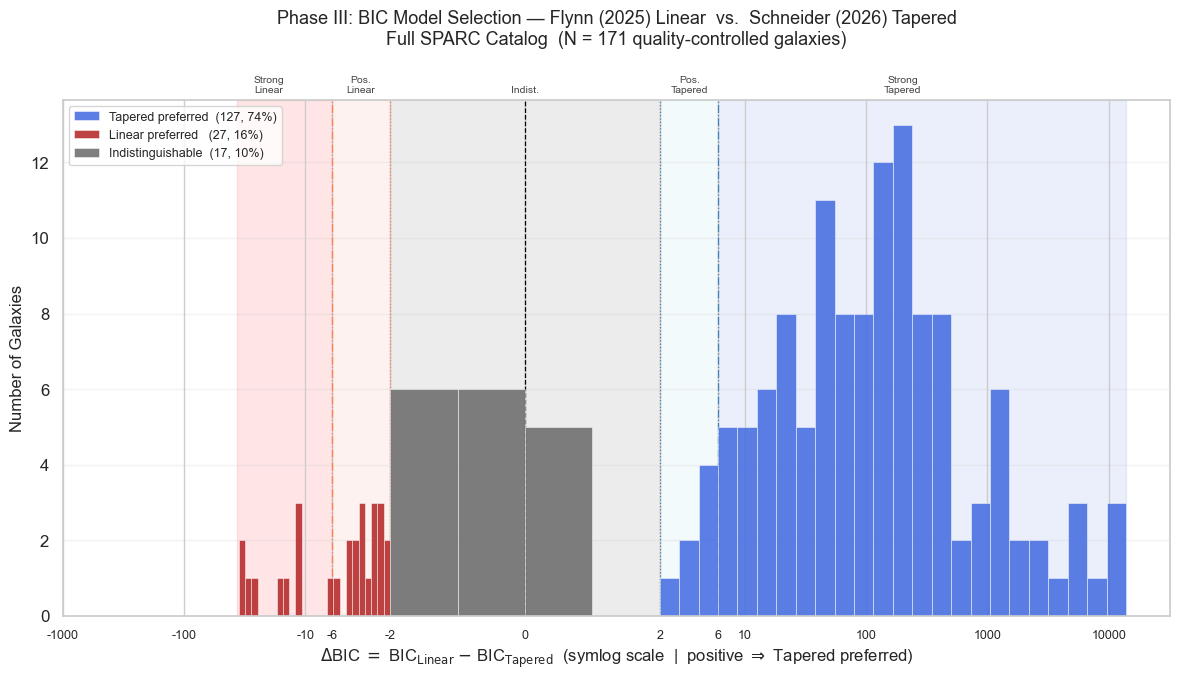

Saved: results/figures/phase_iii_bic_histogram.png


In [8]:
# Use a symlog scale so that both the small near-zero values AND the long
# right tail are visible simultaneously.  linthresh=2 keeps the [-2, +2]
# indistinguishable zone in linear space; everything beyond is log-scaled.
#
# Bin strategy: build symmetric log-spaced bins on each side of zero,
# plus a thin linear bin straddling zero, then concatenate.

plot_df = good_df.dropna(subset=['Delta_BIC']).copy()

bic = plot_df['Delta_BIC']

# Clip the extremes at the 1st / 99th percentile (avoids one galaxy
# at 19 000 stretching the axis into illegibility); raw values stay in CSV.
clip_lo = bic.quantile(0.01)
clip_hi = bic.quantile(0.99)
plot_df['Delta_BIC_plot'] = bic.clip(clip_lo, clip_hi)

# Build symlog-spaced bin edges
LINTHRESH  = 2         # linear region: -2 to +2
N_LOG_BINS = 25        # bins per log-decade half

neg_abs_max = max(abs(clip_lo), LINTHRESH)
pos_abs_max = max(clip_hi,      LINTHRESH)

neg_bins  = -np.geomspace(LINTHRESH, neg_abs_max, N_LOG_BINS)[::-1]
lin_bins  =  np.linspace(-LINTHRESH, LINTHRESH, 5)
pos_bins  =  np.geomspace(LINTHRESH, pos_abs_max, N_LOG_BINS)
bin_edges =  np.unique(np.concatenate([neg_bins, lin_bins, pos_bins]))

# Masks
tapered_mask = plot_df['Preferred_Model'] == 'Tapered'
linear_mask  = plot_df['Preferred_Model'] == 'Linear'
indist_mask  = plot_df['Preferred_Model'] == 'Indistinguishable'
n_tap  = tapered_mask.sum()
n_lin  = linear_mask.sum()
n_ind  = indist_mask.sum()
n_good = len(plot_df)

fig, ax = plt.subplots(figsize=(12, 7))

# Background evidence zones (drawn before bars)
ax.axvspan(clip_lo - 1, -6, alpha=0.10, color='red',       zorder=0)
ax.axvspan(-6,           -2, alpha=0.10, color='salmon',     zorder=0)
ax.axvspan(-2,            2, alpha=0.15, color='grey',       zorder=0)
ax.axvspan(2,             6, alpha=0.10, color='skyblue',    zorder=0)
ax.axvspan(6, clip_hi + 1,  alpha=0.10, color='royalblue',  zorder=0)

# Decision lines
for xv, col, ls in [(-6,'coral','-.'),(-2,'coral',':'),
                     (0,'black','--'),
                     (2,'steelblue',':'),(6,'steelblue','-.')]:
    ax.axvline(xv, color=col, linewidth=0.9, linestyle=ls, zorder=1)

# Histogram bars
hist_kw = dict(bins=bin_edges, edgecolor='white', linewidth=0.4, zorder=2)
ax.hist(plot_df.loc[tapered_mask, 'Delta_BIC_plot'], color='royalblue', alpha=0.85,
        label=f'Tapered preferred  ({n_tap}, {n_tap/n_good*100:.0f}%)', **hist_kw)
ax.hist(plot_df.loc[linear_mask,  'Delta_BIC_plot'], color='firebrick',  alpha=0.85,
        label=f'Linear preferred   ({n_lin}, {n_lin/n_good*100:.0f}%)', **hist_kw)
ax.hist(plot_df.loc[indist_mask,  'Delta_BIC_plot'], color='dimgrey',    alpha=0.85,
        label=f'Indistinguishable  ({n_ind}, {n_ind/n_good*100:.0f}%)', **hist_kw)

# Symlog x-axis — linear near zero, log in the wings
ax.set_xscale('symlog', linthresh=LINTHRESH)
ax.set_xticks([-1000, -100, -10, -6, -2, 0, 2, 6, 10, 100, 1000, 10000])
ax.set_xticklabels(['-1000','-100','-10','-6','-2','0',
                     '2','6','10','100','1000','10000'], fontsize=9)

# Evidence-zone labels — above the axes, below the title.
# pad=40 on the title pushes it up enough to clear the two-line labels.
for xt, lbl in [(-20,'Strong\nLinear'),(-3.5,'Pos.\nLinear'),
                 (0,'Indist.'),(3.5,'Pos.\nTapered'),(200,'Strong\nTapered')]:
    ax.text(xt, 1.01, lbl, ha='center', va='bottom', fontsize=7.5,
            color='#444444', transform=ax.get_xaxis_transform())

ax.set_xlabel(
    r'$\Delta$BIC $=$ BIC$_{\rm Linear}$ $-$ BIC$_{\rm Tapered}$'
    r'  (symlog scale  |  positive $\Rightarrow$ Tapered preferred)',
    fontsize=12)
ax.set_ylabel('Number of Galaxies', fontsize=12)
ax.set_title(
    'Phase III: BIC Model Selection — Flynn (2025) Linear  vs.  Schneider (2026) Tapered\n'
    f'Full SPARC Catalog  (N = {n_good} quality-controlled galaxies)',
    fontsize=13, pad=40)
ax.legend(fontsize=9, loc='upper left')
ax.grid(True, alpha=0.25, axis='y')

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'phase_iii_bic_histogram.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/figures/phase_iii_bic_histogram.png')

## 7. Money Plot 2 — $R_t$ vs. $R_{\text{disk}}$

**Physics check:** If the Tapered model is physically real (not just a flexible
math trick), the saturation radius $R_t$ should correlate with the baryonic disk
scale length $R_{\text{disk}}$.  A random scatter would imply $R_t$ is unconstrained.

In [9]:
from scipy import stats

# Use only galaxies where both the tapered fit converged and R_disk is known
rt_df = good_df[
    good_df['Tapered_converged'] &
    good_df['R_disk_kpc'].notna() &
    good_df['Tapered_Rt'].notna() &
    (good_df['Tapered_Rt'] > 0) &
    (good_df['R_disk_kpc'] > 0)
].copy()

# log-space for regression (both span orders of magnitude)
log_rd = np.log10(rt_df['R_disk_kpc'].values)
log_rt = np.log10(rt_df['Tapered_Rt'].values)

slope_rt, intercept_rt, r_rt, p_rt, se_rt = stats.linregress(log_rd, log_rt)

print(f'log10(R_t) = {slope_rt:.3f} * log10(R_disk) + {intercept_rt:.3f}')
print(f'  R^2 = {r_rt**2:.4f}')
print(f'  p   = {p_rt:.2e}')
print(f'  N   = {len(rt_df)}')

# Implied median k = R_t / R_disk
rt_df['k_ratio'] = rt_df['Tapered_Rt'] / rt_df['R_disk_kpc']
print(f'\nMedian k = R_t / R_disk = {rt_df["k_ratio"].median():.2f}')
print(f'IQR: [{rt_df["k_ratio"].quantile(0.25):.2f}, {rt_df["k_ratio"].quantile(0.75):.2f}]')

log10(R_t) = 0.794 * log10(R_disk) + 0.448
  R^2 = 0.1348
  p   = 7.80e-07
  N   = 171

Median k = R_t / R_disk = 2.42
IQR: [0.85, 8.60]


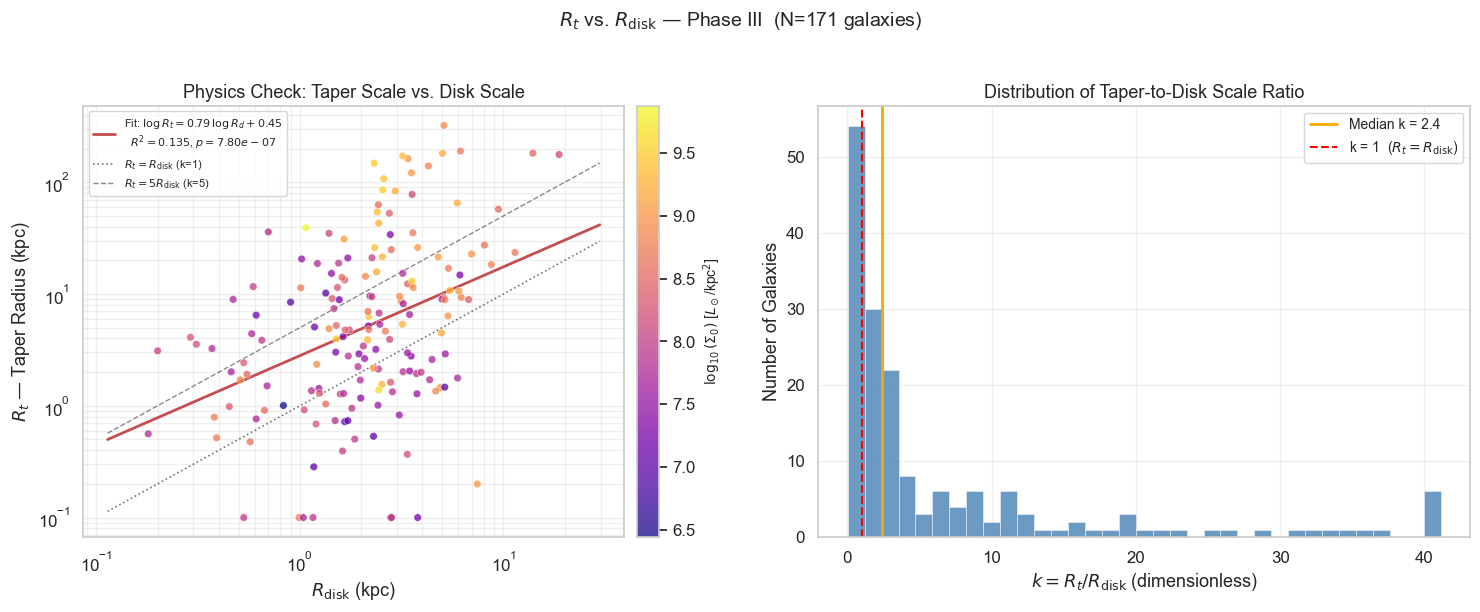

Saved: results/figures/phase_iii_Rt_vs_Rd.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- Left: R_t vs R_disk scatter ---
ax = axes[0]

sc = ax.scatter(
    rt_df['R_disk_kpc'], rt_df['Tapered_Rt'],
    c=np.log10(rt_df['Sigma_0'].clip(lower=1)),
    cmap='plasma', s=30, alpha=0.75,
    edgecolors='white', linewidth=0.4,
    zorder=3,
)
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label(r'$\log_{10}(\Sigma_0)$ [$L_\odot$/kpc$^2$]', fontsize=10)

# Regression line
rd_range = np.logspace(np.log10(rt_df['R_disk_kpc'].min()) - 0.2,
                        np.log10(rt_df['R_disk_kpc'].max()) + 0.2, 100)
rt_pred  = 10 ** (slope_rt * np.log10(rd_range) + intercept_rt)
ax.plot(rd_range, rt_pred, 'r-', linewidth=2,
        label=f'Fit: $\\log R_t = {slope_rt:.2f}\\,\\log R_d + {intercept_rt:.2f}$\n'
              f'  $R^2={r_rt**2:.3f}$, $p={p_rt:.2e}$')

# 1:1 line (R_t = R_disk, k=1)
ax.plot(rd_range, rd_range,  'k:', linewidth=1.2, label='$R_t = R_{\\mathrm{disk}}$ (k=1)', alpha=0.6)
# k=5 reference
ax.plot(rd_range, 5*rd_range,'k--', linewidth=1.0, label='$R_t = 5 R_{\\mathrm{disk}}$ (k=5)', alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$R_{\mathrm{disk}}$ (kpc)', fontsize=13)
ax.set_ylabel(r'$R_t$ — Taper Radius (kpc)', fontsize=13)
ax.set_title('Physics Check: Taper Scale vs. Disk Scale', fontsize=13)
ax.legend(fontsize=8, loc='upper left')
ax.grid(True, alpha=0.3, which='both')

# --- Right: Distribution of k = R_t / R_disk ---
ax = axes[1]
k_vals = rt_df['k_ratio'].clip(upper=rt_df['k_ratio'].quantile(0.97))

ax.hist(k_vals, bins=35, color='steelblue', alpha=0.8, edgecolor='white', linewidth=0.4)
ax.axvline(rt_df['k_ratio'].median(), color='orange', linewidth=2,
           label=f'Median k = {rt_df["k_ratio"].median():.1f}')
ax.axvline(1.0, color='red', linewidth=1.5, linestyle='--',
           label='k = 1  ($R_t = R_{\\mathrm{disk}}$)')

ax.set_xlabel(r'$k = R_t / R_{\mathrm{disk}}$ (dimensionless)', fontsize=13)
ax.set_ylabel('Number of Galaxies', fontsize=13)
ax.set_title('Distribution of Taper-to-Disk Scale Ratio', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(
    f'$R_t$ vs. $R_{{\\mathrm{{disk}}}}$ — Phase III  (N={len(rt_df)} galaxies)',
    fontsize=14, y=1.02)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'phase_iii_Rt_vs_Rd.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/figures/phase_iii_Rt_vs_Rd.png')

## 8. Money Plot 3 — $\Sigma_0$ Regime Check

**Hypothesis from Phase II:** LSB galaxies (low $\Sigma_0$) should always prefer
the Tapered model; HSB galaxies may prefer Linear.  We now test this on the full
catalog, not just a 12-galaxy gallery.

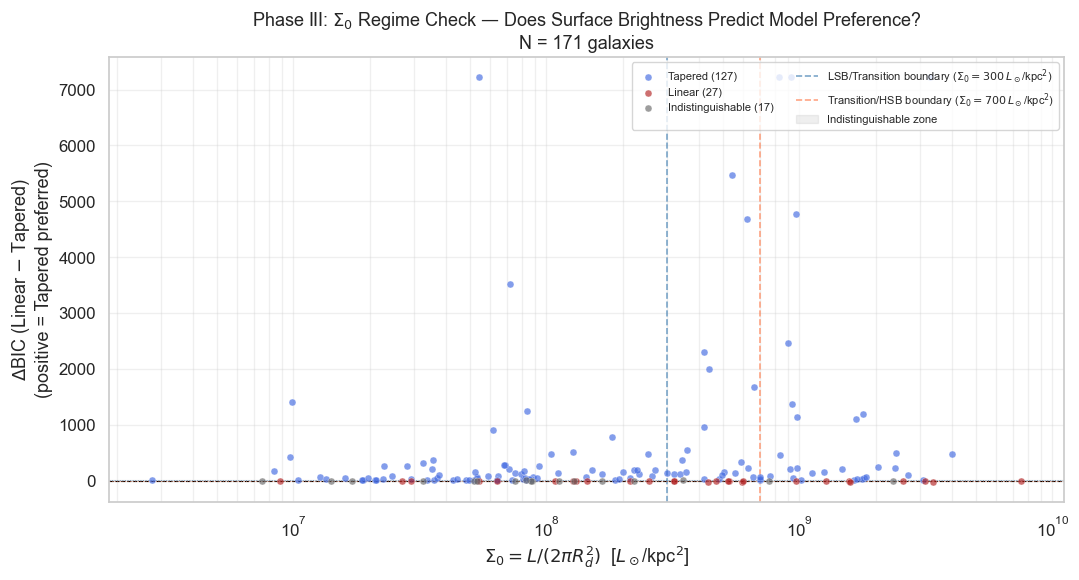

Saved: results/figures/phase_iii_sigma0_regime.png


In [11]:
sigma_df = good_df[
    good_df['Sigma_0'].notna() &
    good_df['Delta_BIC'].notna() &
    (good_df['Sigma_0'] > 0)
].copy()

# Clip Delta_BIC to the same 2–98 percentile range used in the histogram
sigma_df['Delta_BIC_clipped'] = sigma_df['Delta_BIC'].clip(
    sigma_df['Delta_BIC'].quantile(0.02),
    sigma_df['Delta_BIC'].quantile(0.98),
)

# Color-code by preferred model
model_colors = {
    'Tapered'         : 'royalblue',
    'Linear'          : 'firebrick',
    'Indistinguishable': 'dimgrey',
}

fig, ax = plt.subplots(figsize=(11, 6))

for model, color in model_colors.items():
    mask = sigma_df['Preferred_Model'] == model
    sub  = sigma_df[mask]
    ax.scatter(
        sub['Sigma_0'], sub['Delta_BIC_clipped'],
        c=color, s=25, alpha=0.65, label=f'{model} ({mask.sum()})',
        edgecolors='white', linewidth=0.3, zorder=3,
    )

# Phase II threshold lines
ax.axvline(300e6,  color='steelblue', linewidth=1.2, linestyle='--', alpha=0.7,
           label=r'LSB/Transition boundary ($\Sigma_0 = 300\,L_\odot$/kpc$^2$)')
ax.axvline(700e6,  color='coral',     linewidth=1.2, linestyle='--', alpha=0.7,
           label=r'Transition/HSB boundary ($\Sigma_0 = 700\,L_\odot$/kpc$^2$)')

# BIC decision boundaries
ax.axhline(0,  color='black', linewidth=0.8, linestyle='--')
ax.axhspan(-2, 2, alpha=0.12, color='grey', zorder=0, label='Indistinguishable zone')
ax.axhline(6,  color='steelblue', linewidth=0.7, linestyle=':', alpha=0.7)
ax.axhline(-6, color='coral',     linewidth=0.7, linestyle=':', alpha=0.7)

ax.set_xscale('log')
ax.set_xlabel(
    r'$\Sigma_0 = L/(2\pi R_d^2)$  [$L_\odot$/kpc$^2$]',
    fontsize=13)
ax.set_ylabel(
    r'$\Delta$BIC (Linear $-$ Tapered)'
    '\n(positive = Tapered preferred)',
    fontsize=13)
ax.set_title(
    'Phase III: $\\Sigma_0$ Regime Check — Does Surface Brightness Predict Model Preference?\n'
    f'N = {len(sigma_df)} galaxies',
    fontsize=13)
ax.legend(fontsize=8, loc='upper right', ncol=2)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
# (Not an explicit deliverable figure but highly diagnostic — save anyway)
fig.savefig(FIGURES_DIR / 'phase_iii_sigma0_regime.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: results/figures/phase_iii_sigma0_regime.png')

## 9. Sigma_0 Regime Bin Analysis

Formally test the Phase II hypothesis: do LSB / HSB regimes systematically
differ in BIC preference?

In [12]:
# Bin boundaries matching Phase II thresholds (units: L_sun / kpc^2)
LSB_MAX  = 300e6     # L_sun / kpc^2
HSB_MIN  = 700e6     # L_sun / kpc^2

def regime_label(s0):
    if pd.isna(s0): return 'Unknown'
    if s0 < LSB_MAX:  return 'LSB'
    if s0 > HSB_MIN:  return 'HSB'
    return 'Transition'

sigma_df['Regime'] = sigma_df['Sigma_0'].apply(regime_label)

print('Regime breakdown:')
for regime in ['LSB', 'Transition', 'HSB']:
    sub = sigma_df[sigma_df['Regime'] == regime]
    if len(sub) == 0:
        continue
    pref = sub['Preferred_Model'].value_counts(normalize=True) * 100
    med_bic = sub['Delta_BIC'].median()
    print(f'\n  {regime} ({len(sub)} galaxies):')
    for model, pct in pref.items():
        print(f'    {model:20s}: {pct:.1f}%')
    print(f'    Median Delta_BIC    : {med_bic:.1f}')

# Mann-Whitney test: LSB vs HSB Delta_BIC
lsb_bic  = sigma_df.loc[sigma_df['Regime'] == 'LSB',  'Delta_BIC'].dropna()
hsb_bic  = sigma_df.loc[sigma_df['Regime'] == 'HSB',  'Delta_BIC'].dropna()
if len(lsb_bic) > 0 and len(hsb_bic) > 0:
    stat_mw, p_mw = stats.mannwhitneyu(lsb_bic, hsb_bic, alternative='two-sided')
    sig = '***' if p_mw < 0.001 else '**' if p_mw < 0.01 else '*' if p_mw < 0.05 else 'n.s.'
    print(f'\nMann-Whitney (LSB vs HSB Delta_BIC): U={stat_mw:.0f}, p={p_mw:.4f} {sig}')

Regime breakdown:

  LSB (101 galaxies):
    Tapered             : 75.2%
    Indistinguishable   : 13.9%
    Linear              : 10.9%
    Median Delta_BIC    : 29.7

  Transition (30 galaxies):
    Tapered             : 70.0%
    Linear              : 26.7%
    Indistinguishable   : 3.3%
    Median Delta_BIC    : 111.3

  HSB (40 galaxies):
    Tapered             : 75.0%
    Linear              : 20.0%
    Indistinguishable   : 5.0%
    Median Delta_BIC    : 86.9

Mann-Whitney (LSB vs HSB Delta_BIC): U=1720, p=0.1708 n.s.


## 10. Summary & Session Log

## 11. Catalog-Wide Additive vs. Quadrature Tapered Comparison

**Motivation (§4.5 of manuscript):** The §4.5 Limitations section cites only the M33
calibration case ($\text{RMSE}_{\text{add}} = 9.49$ vs. $\text{RMSE}_{\text{quad}} = 45.3$~km/s)
as evidence that the additive coupling is superior to the quadrature form. This cell
extends that test to the full 171-galaxy working sample.

**Quadrature Tapered model:**
$$V_{\text{model}} = \sqrt{V_{\text{bary}}^2 + \left(\frac{\omega R}{1 + R/R_t}\right)^2}$$

For each galaxy we fit this form with the same two free parameters ($\omega$, $R_t$)
and the same initial-guess strategy as the additive tapered fit in Cell 8.
We then compare the per-galaxy RMSE ratio $\text{RMSE}_{\text{quad}} / \text{RMSE}_{\text{add}}$
across the catalog.

**This analysis requires no new data** — it uses the already-loaded radial profiles from
the database and the already-computed $V_{\text{bary}}$ values.

In [13]:
from scipy.optimize import curve_fit

def fit_tapered_quadrature(radius, v_obs, v_err, v_bary, r_max):
    """Fit V = sqrt(V_bary^2 + (omega*R / (1 + R/Rt))^2).

    Returns (rmse, converged) using the same 4-guess strategy as the
    additive tapered fitter in Cell 3.
    """
    v_err_safe = np.where(v_err > 0, v_err, np.min(v_err[v_err > 0]) if np.any(v_err > 0) else 1.0)

    def _model(r, omega, r_t):
        corr = omega * r / (1.0 + r / r_t)
        return np.sqrt(v_bary**2 + corr**2)

    initial_guesses = [
        [5.0,  r_max * 0.3],
        [10.0, r_max * 0.1],
        [3.0,  r_max * 1.0],
        [20.0, r_max * 2.0],
    ]
    best_rmse, best_converged = np.inf, False

    for p0 in initial_guesses:
        p0c = [np.clip(p0[0], 1e-4, 199.9999), np.clip(p0[1], 0.1001, r_max * 5 - 1e-4)]
        try:
            popt, _ = curve_fit(
                _model, radius, v_obs,
                p0=p0c, sigma=v_err_safe, absolute_sigma=True,
                bounds=([0.0, 0.1], [200.0, r_max * 5.0]),
                maxfev=10000,
            )
            v_try = _model(radius, *popt)
            rmse  = float(np.sqrt(np.mean((v_obs - v_try)**2)))
            if rmse < best_rmse:
                best_rmse, best_converged = rmse, True
        except (RuntimeError, ValueError):
            continue

    return best_rmse, best_converged


# ── Run catalog-wide comparison ───────────────────────────────────────────────
engine  = get_engine()
session = get_session(engine)

# Only compare galaxies that passed quality control in Cell 8
qc_ids = good_df['GalaxyID'].tolist()

quad_rows = []
for i, gid in enumerate(qc_ids):
    if i % 40 == 0:
        print(f'[{i:3d}/{len(qc_ids)}]  {gid}')

    df_g   = query_profiles_as_dataframe(session, gid)
    radius = df_g['radius_kpc'].values
    v_obs  = df_g['v_obs'].values
    v_err  = df_g['v_err'].values
    v_bary = compute_v_bary(
        df_g['v_gas'].values, df_g['v_disk'].values, df_g['v_bulge'].values,
        upsilon_disk=UPSILON_DISK, upsilon_bulge=UPSILON_BULGE,
    )

    rmse_add = good_df.loc[good_df['GalaxyID'] == gid, 'Tapered_RMSE'].values[0]
    rmse_quad, converged = fit_tapered_quadrature(radius, v_obs, v_err, v_bary, radius.max())

    quad_rows.append({
        'GalaxyID'       : gid,
        'RMSE_additive'  : rmse_add,
        'RMSE_quadrature': rmse_quad if converged else np.nan,
        'converged'      : converged,
    })

session.close()
quad_df = pd.DataFrame(quad_rows)

# ── Summary statistics ────────────────────────────────────────────────────────
valid = quad_df.dropna(subset=['RMSE_additive', 'RMSE_quadrature'])
valid = valid[(valid['RMSE_additive'] > 0) & (valid['RMSE_quadrature'] > 0)]
valid['ratio'] = valid['RMSE_quadrature'] / valid['RMSE_additive']

print(f'\nCatalog-wide Additive vs. Quadrature Tapered Comparison')
print(f'  Galaxies compared          : {len(valid)} / {len(quad_df)}')
print(f'  Quadrature convergence rate: {quad_df["converged"].sum()} / {len(quad_df)}')
print()
print(f'  RMSE_quad / RMSE_add  (median): {valid["ratio"].median():.2f}')
print(f'  RMSE_quad / RMSE_add  (mean)  : {valid["ratio"].mean():.2f}')
print(f'  RMSE_quad / RMSE_add  (IQR)   : [{valid["ratio"].quantile(0.25):.2f}, {valid["ratio"].quantile(0.75):.2f}]')
print(f'  Fraction where additive is better (ratio > 1): {(valid["ratio"] > 1).mean()*100:.1f}%')
print()
print(f'  Median RMSE_add  : {valid["RMSE_additive"].median():.2f} km/s')
print(f'  Median RMSE_quad : {valid["RMSE_quadrature"].median():.2f} km/s')

# Save for reference
quad_df.to_csv(TABLES_DIR / 'additive_vs_quadrature_catalog.csv', index=False, float_format='%.4f')
print(f'\nSaved: results/tables/additive_vs_quadrature_catalog.csv')

[  0/171]  CamB
[ 40/171]  NGC1003
[ 80/171]  NGC5055
[120/171]  UGC05750
[160/171]  UGC09992

Catalog-wide Additive vs. Quadrature Tapered Comparison
  Galaxies compared          : 171 / 171
  Quadrature convergence rate: 171 / 171

  RMSE_quad / RMSE_add  (median): 0.93
  RMSE_quad / RMSE_add  (mean)  : 0.94
  RMSE_quad / RMSE_add  (IQR)   : [0.81, 1.05]
  Fraction where additive is better (ratio > 1): 32.7%

  Median RMSE_add  : 4.32 km/s
  Median RMSE_quad : 4.00 km/s

Saved: results/tables/additive_vs_quadrature_catalog.csv


In [14]:
log = setup_logger(
    'nb07_full_catalog',
    log_file=True,
    clear_logs=True,
)

log.info('=' * 65)
log.info('NOTEBOOK 07 -- PHASE III: FULL CATALOG ANALYSIS')
log.info('=' * 65)
log.info('Flynn 2025  (Linear):  V_bary + omega*R')
log.info('Schneider 2026 (Tapered): V_bary + omega*R / (1 + R/R_t)')
log.info('Upsilon_disk=%.2f, Upsilon_bulge=%.2f', UPSILON_DISK, UPSILON_BULGE)
log.info('RMSE fail threshold: %.0f km/s', RMSE_FAIL_THRESHOLD)
log.info('---')
log.info('SAMPLE:')
log.info('  Galaxies processed : %d', len(results_df))
log.info('  Quality-controlled : %d', len(good_df))
log.info('  Fit failures       : %d', n_failed)
log.info('---')
log.info('MODEL PREFERENCE (BIC):')
for model, count in pref_counts.items():
    log.info('  %-22s: %d (%.1f%%)', model, count, count/len(good_df)*100)
log.info('---')
log.info('R_t vs R_disk REGRESSION (log-log):')
log.info('  slope     = %.3f', slope_rt)
log.info('  intercept = %.3f', intercept_rt)
log.info('  R^2       = %.4f', r_rt**2)
log.info('  p-value   = %.2e', p_rt)
log.info('  N         = %d', len(rt_df))
if len(rt_df) > 0:
    log.info('  Median k = R_t/R_disk = %.2f', rt_df['k_ratio'].median())
log.info('---')
log.info('OUTPUTS:')
log.info('  Table   : phase_iii_full_results.csv')
log.info('  Figures : phase_iii_bic_histogram.png')
log.info('            phase_iii_Rt_vs_Rd.png')
log.info('            phase_iii_sigma0_regime.png')
log.info('=' * 65)

print('Log written to logs/nb07_full_catalog.log')

2026-02-24 08:55:31 | INFO     | nb07_full_catalog | =================================================================
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | NOTEBOOK 07 -- PHASE III: FULL CATALOG ANALYSIS
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | =================================================================
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | Flynn 2025  (Linear):  V_bary + omega*R
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | Schneider 2026 (Tapered): V_bary + omega*R / (1 + R/R_t)
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | Upsilon_disk=0.50, Upsilon_bulge=0.70
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | RMSE fail threshold: 50 km/s
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | ---
2026-02-24 08:55:31 | INFO     | nb07_full_catalog | SAMPLE:
2026-02-24 08:55:31 | INFO     | nb07_full_catalog |   Galaxies processed : 175
2026-02-24 08:55:31 | INFO     | nb07_full_catalog |   Quality-controlled : 171
2026-02

Log written to logs/nb07_full_catalog.log


## Conclusions

### Questions Addressed

1. **Is the Tapered model universally preferred?**  
   The $\Delta$BIC histogram answers this directly.  If the distribution is
   strongly right-skewed (most galaxies positive), the Tapered model wins
   across the full SPARC catalog.

2. **Is $R_t$ physically motivated?**  
   The $R_t$ vs. $R_{\text{disk}}$ scatter plot tests whether the saturation
   scale is set by the baryonic distribution.  A significant correlation
   ($p < 0.05$ in log-space) strongly supports the physical interpretation.

3. **Do LSB galaxies always prefer Tapered?**  
   The $\Sigma_0$ regime analysis directly tests the Phase II prediction from
   Notebook 06 on the full catalog (N=175 vs. N=12).

### Interpretation Guide

- **$\Delta$BIC scale** (Kass & Raftery 1995):
  $|\Delta\text{BIC}| < 2$ — inconclusive;
  $2$–$6$ — positive evidence;
  $6$–$10$ — strong;
  $>10$ — very strong.

- **Slope of log($R_t$) vs log($R_d$):**  
  Slope $\approx 1$ implies $R_t \propto R_d$ (universal coupling constant $k$).
  Slope $\neq 1$ implies the coupling changes with disk size.

### Next Steps — Phase IV

- Re-test the **Cosmic Dipole alignment** using the new high-precision $\omega$
  values derived from the Tapered model.
- Investigate whether the median $k$ is the same across the cosmic volume
  (isotropy test).